In [1]:
# importing libraries needed for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [2]:
raw_data = pd.read_excel("python_data_2013.xls")
data = raw_data.copy()


## Cleaning Data

In [3]:
data = data.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [4]:
# removing any unnamed columns
for col in data.columns:
    if 'Unnamed' in col:
        del data[col]

In [5]:
data = data[data['MAT $ 2011'] != 0]
data = data[data['MAT $ 2012'] != 0]
data = data[data['MAT $ 2013'] != 0]
data.shape

(1105, 237)

## Adding Features

In [6]:
# mean of occ cost % over 3 years
data['avg_occ_3yrs'] = data[['MAT Occ Cost % 2011', 'MAT Occ Cost % 2012', \
                                     'MAT Occ Cost % 2013']].apply(np.sum, axis=1)/3

In [7]:
imp_feat_list = ['Lease', 'MAT $ CAGR ', 'MAT $ (mo. slope) ', 'avg_occ_3yrs', 'MAT $ PSF Var_Avg ', 'MAT $ PSF Var_slope ', \
                'MAT Occ Cost % (slope) ', 'MAT Occ Cost % CAGR ', 'MAT Occ Cost % CAGR to MAT $ Var ', 'MAT Occ Cost %_Avg_Var _2013',\
                'MAT Occ Cost %_1yr_slope _', 'MAT Occ Cost %_2yr_slope _', 'Month $ PSF % Var_1yr_avg _', 'Month $ PSF % Var_2yr_avg _',\
                'Month $ PSF % Var (1 yr. slope) _', 'Month $ PSF % Var (2 yr. slope) _', 'Non-Holiday Month % Var _2013', \
                'Holiday Month % Var _2013', 'Lease Term (mo.)', 'AR_Past_Due_MAX', 'AR_% of Billings Owed_MAX', \
                'AR_61 - 90_MAX', 'AR_Over 90_MAX', 'AR_2monthover_MAX','National Tenant Flag-Calc','Multi-Tenant Tag (>2)', 'Defaulted']

In [8]:
# data.head()

### Parsing Out Inline Tenants

In [10]:
INL_data = data[data['Lease Space Type-Calc'] == 'INL']
INL_data = INL_data[INL_data['National Tenant Flag-Calc'] == 0]
INL_data = INL_data[INL_data['Multi-Tenant Tag (>2)'] == 0]  # represents tenants that have >2 locations

# shows all the different product categories
print(INL_data['Product Category'].unique())

["S111 US Women's Fashion" 'S521 US Beauty & Health'
 'S491 US Miscellaneous Trades' 'S484 US Electronics & Photo'
 'S231 US Family Shoes' 'S131 US Unisex Fashion' "S211 US Women's Shoes"
 'S311 US Fine Jewelry' 'S441 US Sports Specialties'
 'S451 US Toys, Tobacco and Pets' 'S832 US Service Trades'
 'S486 US Cellular phones' 'S141 US Clothing Sundry - Childrens'
 'S472 US Gifts, Cards & Stationery' "S221 US Men's Shoes"
 'S132 US Teens Fashion' 'S121 US Fashion Men'
 'S153 US Fashion Accessories' 'S596 US Housewares' 'S471 US Newsstands'
 'S452 US Art Galleries' 'S431 US Music' 'S511 US General Trades'
 'S492 US Auto Galleries' 'S321 US Jewelry Accessories' 'Z111 US Not used']


### Filtering Data by Product Category (must pick specific list)

In [11]:
# Product Category list
Prodcat_fashion_list = ["S111 US Women's Fashion", "S131 US Unisex Fashion", "S141 US Clothing Sundry - Childrens",\
                        "S132 US Teens Fashion", "S121 US Fashion Men", "S153 US Fashion Accessories"] #,\"S321 US Jewelry Accessories"]

Prodcat_shoes_list = ["S231 US Family Shoes=", "S211 US Women's Shoes", "S221 US Men's Shoes"]

Prodcat_beauty_list = ["S521 US Beauty & Health", "S452 US Art Galleries"]

# Choose which "Prodcats" to be included in dataset
INL_data = INL_data[INL_data['Product Category'].isin(Prodcat_fashion_list)]

In [13]:
# shows all of the tenants included in dataset
print(INL_data['Product Category'].value_counts())

S111 US Women's Fashion                54
S131 US Unisex Fashion                 38
S153 US Fashion Accessories            13
S141 US Clothing Sundry - Childrens    12
S132 US Teens Fashion                  12
S121 US Fashion Men                     9
Name: Product Category, dtype: int64


### % of tenants that have defaulted within Inline dataset

In [14]:
INL_DEF_Tenants = INL_data[INL_data['Defaulted'] == 1]
print("Number of leases in dataset: ", len(INL_data))
print("Number of defaulted leases in dataset: ", len(INL_DEF_Tenants))
default_percent = "{:.2f}%".format(len(INL_DEF_Tenants)/len(INL_data))  # percent of defaulted tenants in inline dataset
print("Percent of defaulted: ", default_percent)

Number of leases in dataset:  138
Number of defaulted leases in dataset:  17
Percent of defaulted:  0.12%


In [15]:
# Which type of tenants default the most?
INL_DEF_Tenants['Product Category'].value_counts()

S111 US Women's Fashion                12
S141 US Clothing Sundry - Childrens     3
S121 US Fashion Men                     1
S131 US Unisex Fashion                  1
Name: Product Category, dtype: int64

In [16]:
## sorts which malls have greatest number of defaults
pop_mall_defs = INL_data['BU Number-E1'].max()
print(pop_mall_defs)
INL_data[INL_data['BU Number-E1'] == pop_mall_defs]
print("Greatest number of defaults per mall is 2")


12327
Greatest number of defaults per mall is 2


# Random Forrest statistical analysis

In [32]:
# import libraries

from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import DecisionTree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from matplotlib import pyplot as plt



# Set a random seed.
rng = np.random.RandomState(0)

In [33]:
# setting "tree data" to match inline data
tree_list = imp_feat_list
tree_data = INL_data[tree_list].copy()  # make sure to make copy so it's more than reference
tree_data = tree_data.drop('Lease', axis=1)
tree_data = tree_data.dropna(axis=0)
tree_data_X = tree_data.drop('Defaulted', axis=1)


In [34]:
# setting up data for analysis
tree_X = tree_data_X.values
tree_y = tree_data['Defaulted']

In [35]:
# splitting data so as to avoid overfitting
X_train_tree, X_test_tree, y_train_tree, y_test_tree = cross_validation.train_test_split(tree_X, \
                                                                                         tree_y, \
                                                                                         test_size=.5, \
                                                                                         random_state=1)

## Main Computation is here:

In [36]:
# this is the 
rf = RandomForestClassifier(n_estimators=500)
# rf.fit(tree_X, tree_y)
rf.fit(X_train_tree, y_train_tree)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
# testing statistical model output against actual results
# returns accuracy score
cross_val_score(rf, X_test_tree, y_test_tree)

/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)
/Users/brianporter/anaconda3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getarg

array([ 0.875     ,  0.91304348,  0.90909091])

In [38]:
# using statistical model to make predictions on default status
tree_pred_y = rf.predict(tree_X)

In [39]:
# comparing predictions to actual results
list(zip(tree_y, tree_pred_y))

[(1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),

## Find important classifiers

In [40]:
# Thanks Tim for the references

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


# variables for graph input
rand_imp_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rand_imp_feats = []
rand_imp_featnums = []

for f in range(10):
    
    # appending feature names to rand_imp_feats list
    feats = tree_data_X.columns[indices[f]]
    rand_imp_feats.append(feats)
    # appending feature values to rand_imp_featnums list
    featnums = importances[indices[f]]
    rand_imp_featnums.append(featnums)

    print("%d. feature %s (%f)" % (f + 1, tree_data_X.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature AR_Past_Due_MAX (0.149038)
2. feature AR_Over 90_MAX (0.067923)
3. feature Month $ PSF % Var (1 yr. slope) _ (0.063374)
4. feature MAT Occ Cost %_1yr_slope _ (0.055698)
5. feature MAT Occ Cost %_Avg_Var _2013 (0.055552)
6. feature AR_% of Billings Owed_MAX (0.047480)
7. feature MAT Occ Cost %_2yr_slope _ (0.047186)
8. feature MAT Occ Cost % CAGR to MAT $ Var  (0.046329)
9. feature AR_61 - 90_MAX (0.046064)
10. feature MAT Occ Cost % (slope)  (0.042978)


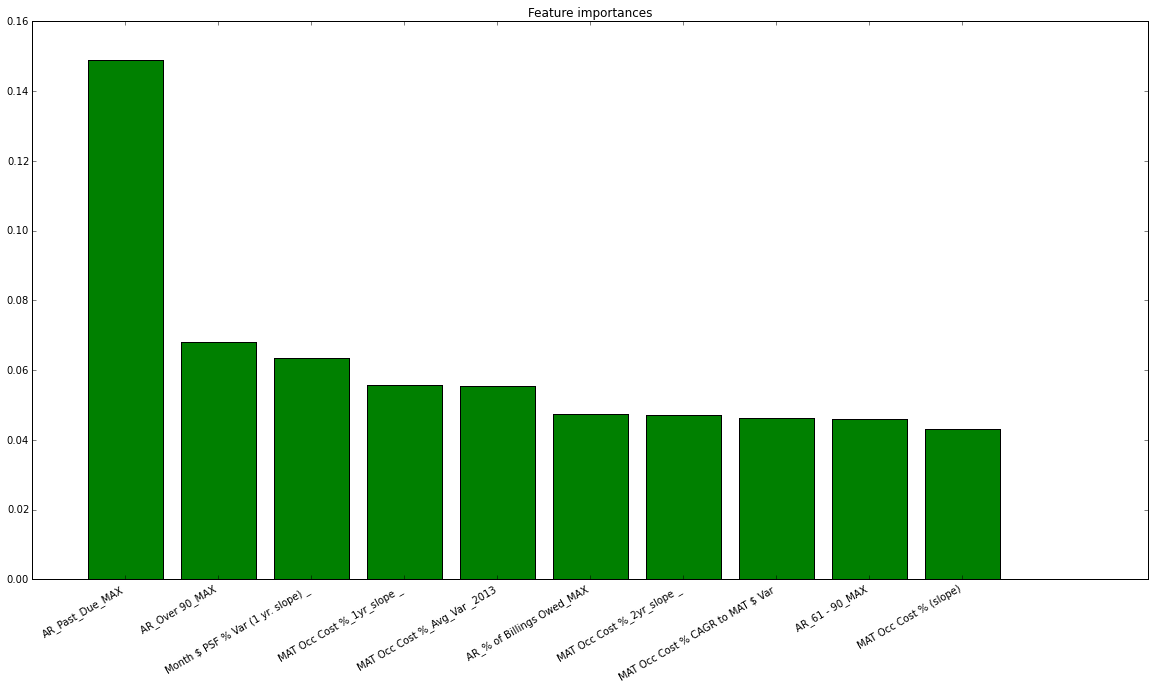

In [41]:
# Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(rand_imp_range, rand_imp_featnums,
       color="g", align="center")
plt.xticks(rand_imp_range, rand_imp_feats, rotation=30, ha='right')
plt.show()


